In [11]:
import torch
from monai.networks.nets import UNETR

In [41]:
import torch

# Load the scripted model
model = torch.jit.load("D:/master/1st_semester/Deep_Learning/project/DeepM/UNETR_model_best_acc.pt", map_location=torch.device('cpu'))

# Example input tensor (adjusted for 3D input size and 1 channel)
dummy_input = torch.randn(1, 1, 96, 96, 96)  # Adjusted for 3D input with shape (batch_size, in_channels, depth, height, width)

# Perform inference
output = model(dummy_input)

# Print the output shape
print(output.shape)  # The output shape will depend on the model's design, likely (1, 14, 96, 96, 96) if out_channels=14


torch.Size([1, 14, 96, 96, 96])


## Load the Pretrained model

In [186]:
import os

model = UNETR(
    in_channels=1,
    out_channels=14,
    img_size=(64, 64, 64),
    feature_size=8,
    hidden_size=256,
    mlp_dim=1024,
    num_heads=8,
    norm_name="instance",  # Removed proj_type
    res_block=True,
    dropout_rate=0.0,
)

model.load_state_dict(torch.load(os.path.join("D:/master/1st_semester/Deep_Learning/project/DeepM/", "best_metric_model.pth")))

C:\Users\Amin-\AppData\Local\Temp\ipykernel_30156\319760341.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join("D:/master/1st

<All keys matched successfully>

In [ ]:
model = model.cuda()  # Ensure the model is on the correct device (GPU/CPU)


## Create Conf File for Training and Validation

In [171]:
import os
import json

def create_json(dataset_dir, json_output_path):
    # Initialize dictionary for the dataset configuration
    dataset_config = {
        "training": [],
        "testing": []
    }

    # Iterate over the "training" and "testing" directories
    for phase in ['training', 'testing']:
        phase_dir = os.path.join(dataset_dir, phase)
        
        # Iterate over each patient directory in the phase
        for patient_dir in os.listdir(phase_dir):
            patient_path = os.path.join(phase_dir, patient_dir)
            
            # Make sure it's a directory
            if os.path.isdir(patient_path):
                # Collect image-label pairs for each frame in the patient's directory
                for file in os.listdir(patient_path):
                    # Only consider .nii.gz files
                    if file.endswith('.nii.gz'):
                        # Assuming files are named like 'patient_frame01.nii.gz' and 'patient_frame01_gt.nii.gz'
                        frame_name = file.replace('.nii.gz', '')
                        if '_gt' in file:
                            # This is the ground truth (label)
                            label_path = os.path.join(patient_path, file)
                            image_path = label_path.replace('_gt', '')  # Get the corresponding image path
                            
                            # Add to the list of image-label pairs
                            dataset_config[phase].append({
                                "image": image_path,
                                "label": label_path
                            })
    
    # Write the dictionary to a JSON file
    with open(json_output_path, 'w') as json_file:
        json.dump(dataset_config, json_file, indent=4)

# Set dataset directory and output path
dataset_dir = 'D:/master/1st_semester/Deep_Learning/project/DeepM/MIS-working-database'  # Replace with the path to your dataset folder
json_output_path = 'dataset_config.json'  # Path where the JSON file will be saved

# Create the JSON file
create_json(dataset_dir, json_output_path)
print(f"JSON configuration file created at {json_output_path}")


JSON configuration file created at dataset_config.json


## Setup transforms for training and validation

In [187]:
import json
from monai.data import CacheDataset, DataLoader, load_decathlon_datalist
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd, ScaleIntensityRanged, CropForegroundd, Resized

# Define the transformation pipelines (same as before)
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Resized(keys=["image", "label"], spatial_size=(64, 64, 64), mode="nearest"),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Resized(keys=["image", "label"], spatial_size=(64, 64, 64), mode="nearest"),
    ]
)

# Load the dataset
base_directory = 'D:/master/1st_semester/Deep_Learning/project/DeepM'
split_json = "dataset_config.json"
datasets = os.path.join(base_directory, split_json)
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")

# Create datasets
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=4,
    cache_rate=1.0,
    num_workers=8,
)

val_ds = CacheDataset(
    data=val_files,
    transform=val_transforms,
    cache_num=6,
    cache_rate=1.0,
    num_workers=4,
)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)


Loading dataset: 100%|██████████| 6/6 [00:00<00:00,  8.88it/s]


In [181]:
import torch.optim as optim

# Loss function: CrossEntropyLoss for multi-class segmentation
criterion = torch.nn.CrossEntropyLoss()

# Optimizer: Adam (you can also use AdamW for better weight decay)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Optionally, adjust learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [ ]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
)
from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR
from monai.data import (
    decollate_batch,
)
import torch
print_config()

## Execute the Training

In [189]:
# Loss function
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)

# Optimizer
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [191]:
root_dir = 'D:/master/1st_semester/Deep_Learning/project/DeepM'
# Mixed precision setup, only enable if CUDA is available
scaler = None
if torch.cuda.is_available():
    scaler = torch.cuda.amp.GradScaler()

# Validation function
def validation(epoch_iterator_val):
    model.eval()
    dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].to(device), batch["label"].to(device))
            val_outputs = sliding_window_inference(val_inputs, (64, 64, 64), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

# Training function with gradient accumulation
accumulation_steps = 2  # Adjust based on memory constraints

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = batch["image"].to(device), batch["label"].to(device)
        
        # Mixed precision forward pass only if CUDA is available
        if torch.cuda.is_available():
            with torch.cuda.amp.autocast():  # Mixed precision
                logit_map = model(x)
                loss = loss_function(logit_map, y)
        else:
            # Regular forward pass if CUDA is not available
            logit_map = model(x)
            loss = loss_function(logit_map, y)

        # Gradient accumulation
        if torch.cuda.is_available():
            # Backward pass with scaling for mixed precision
            scaler.scale(loss).backward()  
        else:
            # Regular backward pass if not using mixed precision
            loss.backward()

        if (step + 1) % accumulation_steps == 0 or (step + 1) == len(epoch_iterator):
            if torch.cuda.is_available():
                scaler.step(optimizer)  # Optimizer step with scaler
                scaler.update()  # Update the scaler
            else:
                optimizer.step()  # Normal optimizer step for CPU
            optimizer.zero_grad()

        epoch_loss += loss.item()
        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss.item():.5f})")

        # Validation and checkpoint saving
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)

            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "finetune_best_metric_model.pth"))
                print(f"Model Saved! Best Avg. Dice: {dice_val_best} Current Avg. Dice: {dice_val}")
            else:
                print(f"Model Not Saved. Best Avg. Dice: {dice_val_best} Current Avg. Dice: {dice_val}")

            # Free GPU memory after validation
            torch.cuda.empty_cache()

        global_step += 1
    return global_step, dice_val_best, global_step_best

# Training loop
max_iterations = 10000
eval_num = 500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)

global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)

# Load the best model after training
model.load_state_dict(torch.load(os.path.join(root_dir, "finetune_best_metric_model.pth")))

Training (500 / 10000 Steps) (loss=1.85499):  64%|██████▎   | 121/190 [03:35<21:16, 18.50s/it]

Model Saved! Best Avg. Dice: 0.39822182059288025 Current Avg. Dice: 0.39822182059288025


Training (1000 / 10000 Steps) (loss=1.65501):  27%|██▋       | 51/190 [02:12<42:29, 18.34s/it]

Model Saved! Best Avg. Dice: 0.4261191487312317 Current Avg. Dice: 0.4261191487312317


Training (1500 / 10000 Steps) (loss=1.45314):  90%|█████████ | 171/190 [04:29<05:44, 18.11s/it]

Model Saved! Best Avg. Dice: 0.5385987758636475 Current Avg. Dice: 0.5385987758636475


Training (2000 / 10000 Steps) (loss=1.32170):  53%|█████▎    | 101/190 [03:10<27:15, 18.38s/it]

Model Saved! Best Avg. Dice: 0.5809350609779358 Current Avg. Dice: 0.5809350609779358


Training (2500 / 10000 Steps) (loss=1.22979):  16%|█▋        | 31/190 [01:50<48:52, 18.44s/it]

Model Saved! Best Avg. Dice: 0.5811004638671875 Current Avg. Dice: 0.5811004638671875


Training (3000 / 10000 Steps) (loss=1.15259):  79%|███████▉  | 151/190 [04:35<12:56, 19.90s/it]

Model Saved! Best Avg. Dice: 0.6027911305427551 Current Avg. Dice: 0.6027911305427551


Training (3500 / 10000 Steps) (loss=1.08897):  43%|████▎     | 81/190 [02:55<35:12, 19.38s/it]

Model Saved! Best Avg. Dice: 0.6179898977279663 Current Avg. Dice: 0.6179898977279663


Training (4000 / 10000 Steps) (loss=1.05815):   6%|▌         | 11/190 [01:24<54:13, 18.18s/it]

Model Not Saved. Best Avg. Dice: 0.6179898977279663 Current Avg. Dice: 0.5989806652069092


Training (4500 / 10000 Steps) (loss=1.01458):  69%|██████▉   | 131/190 [03:40<18:23, 18.71s/it]

Model Saved! Best Avg. Dice: 0.636605978012085 Current Avg. Dice: 0.636605978012085


Training (5000 / 10000 Steps) (loss=0.99929):  32%|███▏      | 61/190 [02:21<39:31, 18.39s/it]

Model Saved! Best Avg. Dice: 0.642977774143219 Current Avg. Dice: 0.642977774143219


Training (5500 / 10000 Steps) (loss=0.94052):  95%|█████████▌| 181/190 [04:37<02:48, 18.68s/it]

Model Saved! Best Avg. Dice: 0.6448101997375488 Current Avg. Dice: 0.6448101997375488


Training (6000 / 10000 Steps) (loss=0.93737):  58%|█████▊    | 111/190 [03:17<24:15, 18.42s/it]

Model Not Saved. Best Avg. Dice: 0.6448101997375488 Current Avg. Dice: 0.6342686414718628


Training (6500 / 10000 Steps) (loss=0.91923):  22%|██▏       | 41/190 [02:00<44:42, 18.00s/it]

Model Saved! Best Avg. Dice: 0.6499131917953491 Current Avg. Dice: 0.6499131917953491


Training (7000 / 10000 Steps) (loss=0.89856):  85%|████████▍ | 161/190 [04:15<09:03, 18.75s/it]

Model Not Saved. Best Avg. Dice: 0.6499131917953491 Current Avg. Dice: 0.6439799666404724


Training (7500 / 10000 Steps) (loss=0.87305):  48%|████▊     | 91/190 [03:09<32:22, 19.62s/it]

Model Saved! Best Avg. Dice: 0.659526526927948 Current Avg. Dice: 0.659526526927948


Training (8000 / 10000 Steps) (loss=0.86267):  11%|█         | 21/190 [01:45<56:30, 20.06s/it]

Model Not Saved. Best Avg. Dice: 0.659526526927948 Current Avg. Dice: 0.654489278793335


Training (8500 / 10000 Steps) (loss=0.85229):  74%|███████▍  | 141/190 [04:10<16:22, 20.04s/it]

Model Not Saved. Best Avg. Dice: 0.659526526927948 Current Avg. Dice: 0.6577951908111572


Training (9000 / 10000 Steps) (loss=0.85550):  37%|███▋      | 71/190 [02:53<40:43, 20.53s/it]

Model Not Saved. Best Avg. Dice: 0.659526526927948 Current Avg. Dice: 0.6528152227401733


Training (9500 / 10000 Steps) (loss=0.83488):   1%|          | 1/190 [01:21<4:15:41, 81.17s/it]

Model Not Saved. Best Avg. Dice: 0.659526526927948 Current Avg. Dice: 0.6552780270576477


Training (10000 / 10000 Steps) (loss=0.83232):  64%|██████▎   | 121/190 [04:07<28:35, 24.86s/it]

Model Not Saved. Best Avg. Dice: 0.659526526927948 Current Avg. Dice: 0.6492674350738525


Training (10069 / 10000 Steps) (loss=0.81856): 100%|██████████| 190/190 [05:44<00:00,  1.81s/it]
C:\Users\Amin-\AppData\Local\Temp\ipykernel_30156\4194693992.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues r

<All keys matched successfully>

## Plot the loss and Dice metric

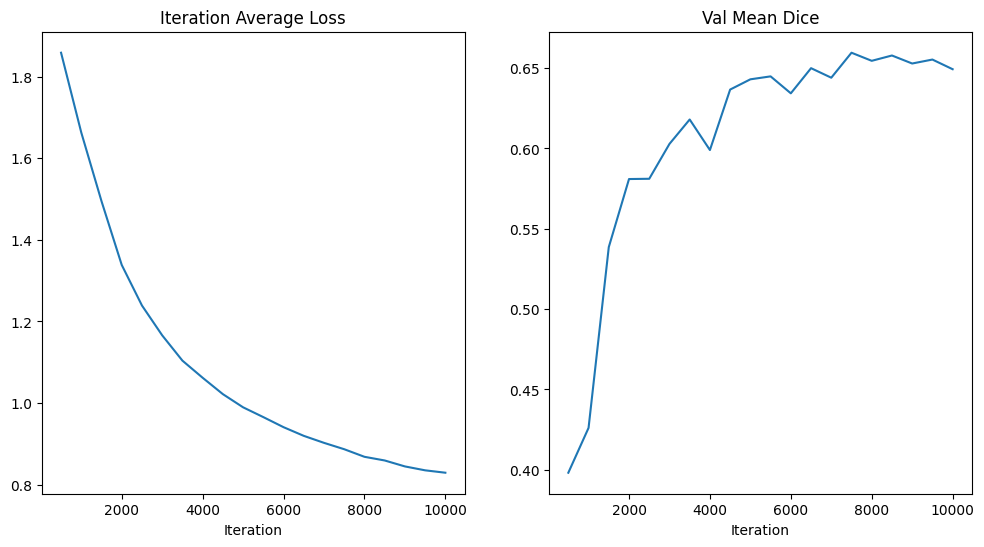

In [192]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

## Evaluation of The Best Fine Tuned Model

In [193]:
import torch
import numpy as np
import os
from sklearn.metrics import f1_score, mean_squared_error, confusion_matrix, recall_score, precision_score
import warnings

# Suppress UserWarnings (which includes UndefinedMetricWarning)
warnings.simplefilter("ignore", category=UserWarning)

# Assuming model is already defined and pretrained
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load(os.path.join(root_dir, "finetune_best_metric_model.pth"), weights_only=True))
model.eval()

# Initialize metric trackers
all_labels = []
all_preds = []

# Variables to accumulate MSE, RMSE, IoU, Recall, and Precision across all batches
mse_total = 0
rmse_total = 0
iou_total = 0
recall_total = 0
precision_total = 0
batch_count = 0

# IoU calculation function
def iou_score(pred, target):
    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target) - intersection
    return intersection / (union + 1e-6)  # Add a small value to avoid division by zero

# Loop through the validation data loader
for val_data in val_loader:
    val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device)

    # Forward pass to get predictions
    with torch.no_grad():
        val_outputs = model(val_inputs)

    # Convert predictions to class labels (for evaluation metrics)
    val_preds = torch.argmax(val_outputs, dim=1).cpu().numpy()  # for multi-class
    val_labels_np = val_labels.cpu().numpy()

    # Collect the ground truth and predicted labels
    all_labels.append(val_labels_np)
    all_preds.append(val_preds)

    # MSE and RMSE (accumulate for the final calculation)
    mse = mean_squared_error(val_labels_np.flatten(), val_preds.flatten())
    rmse = np.sqrt(mse)
    mse_total += mse
    rmse_total += rmse

    # F1 Score (weighted)
    f1 = f1_score(val_labels_np.flatten(), val_preds.flatten(), average="weighted")

    # Recall (weighted)
    recall = recall_score(val_labels_np.flatten(), val_preds.flatten(), average="weighted", zero_division=0)
    recall_total += recall

    # Precision (weighted)
    precision = precision_score(val_labels_np.flatten(), val_preds.flatten(), average="weighted", zero_division=0)
    precision_total += precision

    # For IoU (binary segmentation or multi-class segmentation)
    # Assuming binary segmentation or we calculate IoU per class in multi-class
    if val_labels.size(1) == 1:  # Binary segmentation (single channel output)
        pred = torch.sigmoid(val_outputs)  # Apply sigmoid for binary segmentation (logits)
        pred = (pred > 0.5).float()  # Threshold at 0.5 for binary prediction
        iou = iou_score(pred, val_labels)  # Calculate IoU
    else:  # Multi-class case, calculate IoU per class
        # Loop through each class
        iou = 0
        num_classes = val_labels.max().item() + 1  # Get number of classes
        for class_id in range(num_classes):
            pred_class = (val_preds == class_id).astype(np.float32)
            target_class = (val_labels_np == class_id).astype(np.float32)
            iou_class = iou_score(torch.tensor(pred_class), torch.tensor(target_class))
            iou += iou_class
        iou /= num_classes  # Average IoU over all classes

    iou_total += iou.item()  # Accumulate IoU for averaging

    batch_count += 1  # Count number of batches

# After looping through all batches, calculate overall metrics
all_labels = np.concatenate(all_labels, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

# Calculate overall Recall score (weighted)
overall_recall = recall_score(all_labels.flatten(), all_preds.flatten(), average="weighted")
print(f"Overall Recall Score: {overall_recall:.4f}")

# Calculate overall Precision score (weighted)
overall_precision = precision_score(all_labels.flatten(), all_preds.flatten(), average="weighted", zero_division=0)
print(f"Overall Precision Score: {overall_precision:.4f}")

# Calculate overall F1 score (weighted)
overall_f1 = f1_score(all_labels.flatten(), all_preds.flatten(), average="weighted")
print(f"Overall F1 Score: {overall_f1:.4f}")

# Calculate average MSE and RMSE across all batches
average_mse = mse_total / batch_count
average_rmse = rmse_total / batch_count
print(f"Average MSE: {average_mse:.4f}")
print(f"Average RMSE: {average_rmse:.4f}")

# Calculate average IoU across all batches
average_iou = iou_total / batch_count
print(f"Average IoU Score: {average_iou:.4f}")

# Optionally, print the confusion matrix for the whole validation set
cm = confusion_matrix(all_labels.flatten(), all_preds.flatten())
print(f"Confusion Matrix:\n{cm}")


Overall Recall Score: 0.9762
Overall Precision Score: 0.9758
Overall F1 Score: 0.9759
Average MSE: 0.0710
Average RMSE: 0.2599
Average IoU Score: 0.2082
Confusion Matrix:
[[25078350    83752   101618    31561]
 [  126303   155492    12624    14977]
 [  113052    15156   158044    16459]
 [   32361    12220    63047   199384]]
